In [103]:
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import pickle
import cv2
import glob
import warnings

In [2]:
# Loading the dataset
Cars = glob.glob('data/vehicles/**/*.png')
Non_Cars = glob.glob('data/non-vehicles/**/*.png')

In [3]:
print('Number of car images: {}'.format(len(Cars)))
print('Number of non-car images: {}'.format(len(Non_Cars)))

Number of car images: 8792
Number of non-car images: 8968


In [61]:
#### Feature Extractio Using HOG ####
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    
    hog_output = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                     cells_per_block=(cell_per_block, cell_per_block), 
                     visualise=vis, block_norm='L2', feature_vector=feature_vec)
    
    ## Call with two outputs if vis==True
    if vis == True:
        return hog_output[0], hog_output[1]
    ## Otherwise call with one output
    else:
        return hog_output

In [96]:
# Extract Important Features Using HOG Definition
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for i in imgs:
        image = mpimg.imread(i)
        if cspace != 'RGB':
            if cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            if cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        else: feature_image = np.copy(image)

        if hog_channel == 'ALL':
            hog_features = []
            if len(feature_image.shape) == 2:
                hog_features.append(get_hog_features(feature_image, 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            else:
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
    return features

In [111]:
#### Get Your HOG Features From Negitive and Positive Samples ####
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
## Get Features for Positive Samples
Features1 = extract_features(Cars, cspace=colorspace, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)
## Get Features for Negitive Samples
Features2 = extract_features(Non_Cars, cspace=colorspace, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)

In [112]:
## Create Features
X = np.vstack((Features1, Features2)).astype(np.float64)  
## Create Labels
y = np.hstack((np.ones(len(Features1)), np.zeros(len(Features2))))
## Split Training and Test Data
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
                 X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# # Apply the scaler to X_train and test
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# X_train_scaled = X_train
# X_test_scaled = X_test

# Train a Support Vector Machine

In [115]:
parameters = {'C':list(range(1,10))}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [116]:
clf.best_params_

{'C': 3}

In [121]:
svc = SVC(C=3)
svc.fit(X_train_scaled, y_train)
print(classification_report(y_test, svc.predict(X_test_scaled)))

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00      1779
        1.0       1.00      0.99      1.00      1773

avg / total       1.00      1.00      1.00      3552



In [122]:
## Show the Accuracy
print('Test Accuracy =', round(svc.score(X_test_scaled, y_test), 4))

Test Accuracy = 0.9952


In [231]:
#### Estimate the Location of Object of Interest and Draw Box Around Your Object 
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    rectangles = []  
    # Hack for 0-255 images
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        else: ctrans_tosearch = np.copy(img_tosearch)       
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))    
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    ## Compute HOG for Individual Channel
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    x_offset = (imshape[1] - (nxsteps+1) * cells_per_step * pix_per_cell) // 2
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step + x_offset
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            hog_features_scaled = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(hog_features_scaled)        
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
    return rectangles

In [124]:
## Draw Bounding Boxes ##
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [125]:
def draw_labeled_bboxes(img, labels):
    rects = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img, rects

In [126]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [127]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

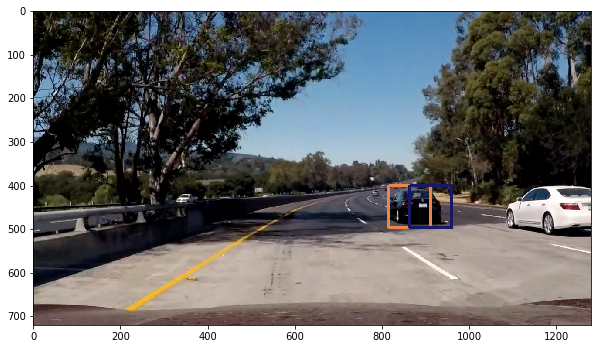

In [244]:
#### First Step Towards Finding the Object of Interest #### 
test_img = mpimg.imread('test_images/test5.jpg')
ystart = 400
ystop = 496
scale = 1.5
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell,
                       cell_per_block, None, None, False)
## Draw the Boxes Around the Image
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

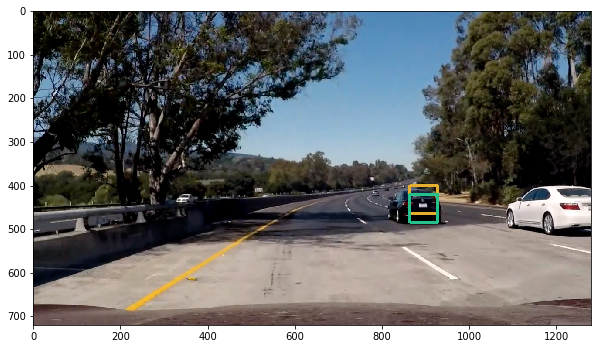

In [243]:
## Tune the Model on the Same Image ##
test_img = mpimg.imread('test_images/test5.jpg')
rects = []
ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
ystart = 420
ystop = 484
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

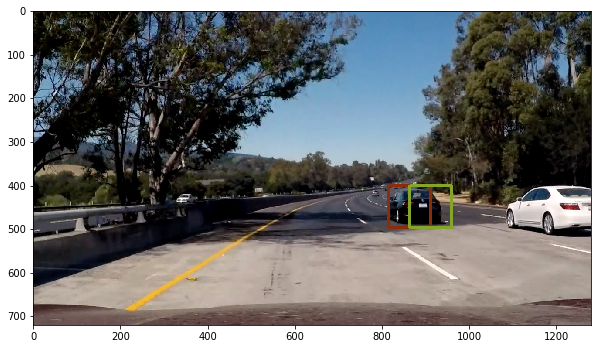

In [245]:
# Add medium boxes
test_img = mpimg.imread('test_images/test5.jpg')
rects = []
ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
ystart = 432
ystop = 526
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

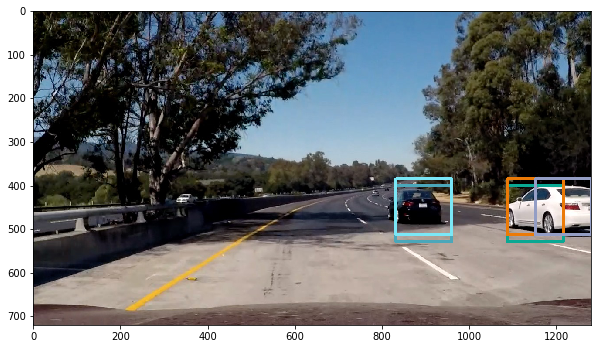

In [255]:
# Add medium boxes
test_img = mpimg.imread('test_images/test5.jpg')
rects = []
ystart = 400
ystop = 528
scale = 2
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
ystart = 384
ystop = 512
scale = 2
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

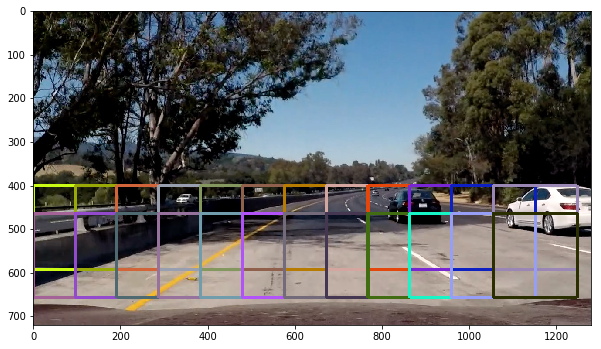

In [222]:
# Add large boxes
test_img = mpimg.imread('test_images/test5.jpg')
rects = []
ystart = 400
ystop = 592
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 656
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

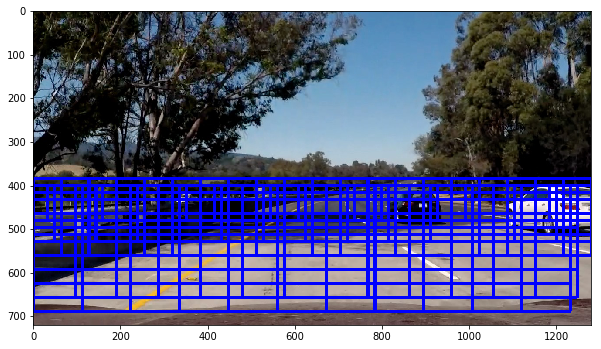

In [251]:
## Show search pattern
test_img = mpimg.imread('test_images/test5.jpg')
rectangles = []
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
ystart = 384
ystop = 512
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))

ystart = 400
ystop = 592
scale = 3.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 656
scale = 3.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

ystart = 400
ystop = 624
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
ystart = 464
ystop = 688
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

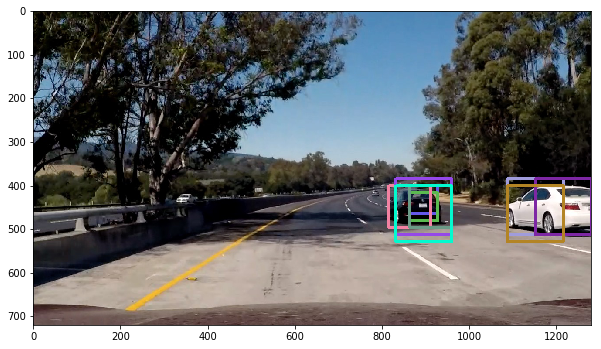

In [252]:
## Finally Tune the Model With More Accurate Location
test_img = mpimg.imread('test_images/test5.jpg')
rectangles = []
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 384
ystop = 512
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))

ystart = 400
ystop = 592
scale = 3.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 464
ystop = 656
scale = 3.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))

ystart = 400
ystop = 624
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
ystart = 464
ystop = 688
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

2 cars found


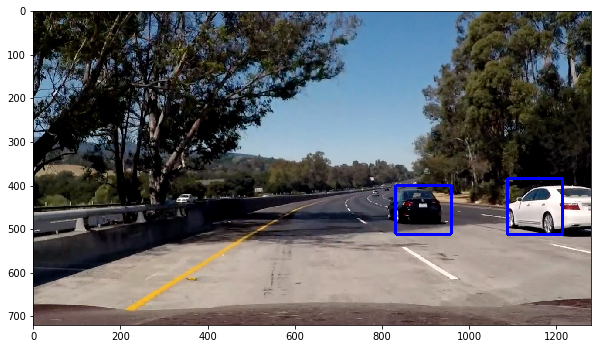

In [253]:
#### Draw The Bounding Boxes Around the Object of Interest
heatmap = np.zeros(test_img.shape[:2])
heatmap = add_heat(heatmap, rectangles)
heatmap = apply_threshold(heatmap, 1)
labels = label(heatmap)
print(labels[1], 'cars found')


draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [256]:
# Define the Complete PipLine for Object Detection 
def process_frame(img):
    rectangles = []
    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 384
    ystop = 512
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))

    ystart = 400
    ystop = 592
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 464
    ystop = 656
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))

    ystart = 400
    ystop = 624
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    ystart = 464
    ystop = 688
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, None, None, False))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    heatmap_img = np.zeros(img.shape[:2])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img) 
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

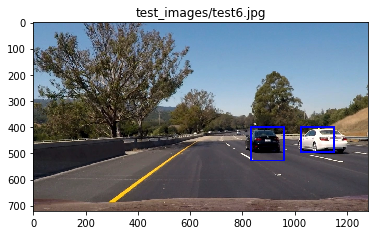

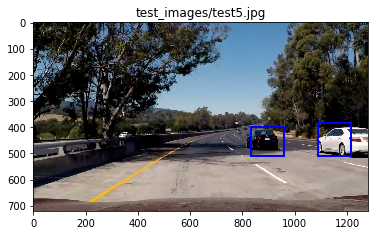

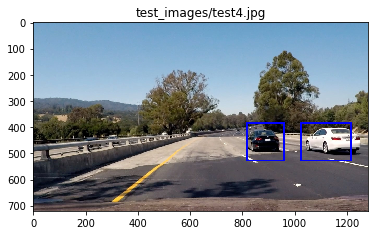

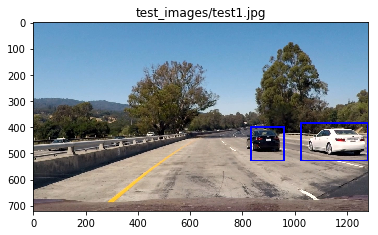

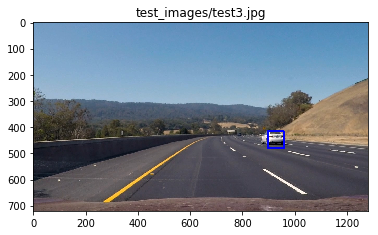

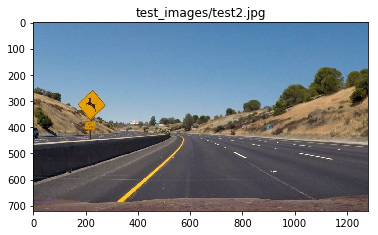

In [257]:
# Load the Test Images to Detect the Objects
test_images = glob.glob('test_images/*.jpg')
for imgPath in test_images:
    drImg = process_frame(mpimg.imread(imgPath))
    plt.title(imgPath)
    plt.imshow(drImg)
    plt.show()

# Process video

In [260]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputPath = "output_videos/project_video.mp4"
inputPath = "project_video.mp4"

In [ ]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
# clip1 = VideoFileClip(inputPath).subclip(0,2)
clip1 = VideoFileClip(inputPath)
output_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time output_clip.write_videofile(outputPath, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  9%|▉         | 119/1261 [04:46<45:40,  2.40s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputPath))